In [18]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline 

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [59]:
block_size = 3
X, Y = [], []
for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)

In [61]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [16]:
C = torch.rand((27,2))

In [20]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [31]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [32]:
h = torch.tanh(emb.view(-1,6) @ W1+b1)

In [33]:
h.shape

torch.Size([32, 100])

In [34]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [35]:
logits = h @ W2 + b2

In [36]:
logits.shape

torch.Size([32, 27])

In [37]:
counts = logits.exp()

In [38]:
prob = counts / counts.sum(1, keepdims = True)

In [42]:
loss = -prob[torch.arange(32), Y].log().mean()

In [43]:
loss

tensor(15.5598)

In [110]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6,100), generator = g)
b1 = torch.randn(100, generator = g)
W2 = torch.randn((100,27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

In [111]:
sum(p.nelement() for p in parameters)

3481

In [112]:
for p in parameters:
    p.requires_grad = True


In [113]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [132]:
lri = []
lossi = []

for i in range(10000):
    
    #minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 +b1)
    logits = h @ W2 +b2
    loss = F.cross_entropy(logits, Y[ix])
    #print(f'Epoch: {i+1} Loss:{loss.item():.3f}')
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #lr = lrs[i]
    
    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # tracking
    #lri.append(lre[i])
    #lossi.append(loss.item())
print(loss.item())

2.254523515701294


In [133]:
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 +b1)
logits = h @ W2 +b2
loss = F.cross_entropy(logits, Y)
print(f'Loss:{loss.item():.3f}')

Loss:2.278


In [ ]:
plt.plot(lri, lossi)
print(min)

In [141]:
# Train validate test
def build_dataset(words, block = 3):
    block_size = block
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8* len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
    

In [142]:
Xtr.shape, Ytr.shape

(torch.Size([182441, 3]), torch.Size([182441]))

In [183]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator = g)
W1 = torch.randn((30,200), generator = g)
b1 = torch.randn(200, generator = g)
W2 = torch.randn((200,27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

In [184]:
sum(p.nelement() for p in parameters)

11897

In [185]:
for p in parameters:
    p.requires_grad = True

In [200]:
lri = []
lossi = []
stepi = []

In [201]:
for i in range(50000):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,30) @ W1 +b1)
    logits = h @ W2 +b2
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(f'Epoch: {i+1} Loss:{loss.item():.3f}')
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #lr = lrs[i]
    
    # update
    lr = 0.1 if i < 25000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # tracking
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
print(f'Training Loss:{loss.item():.3f}')

Training Loss:2.217


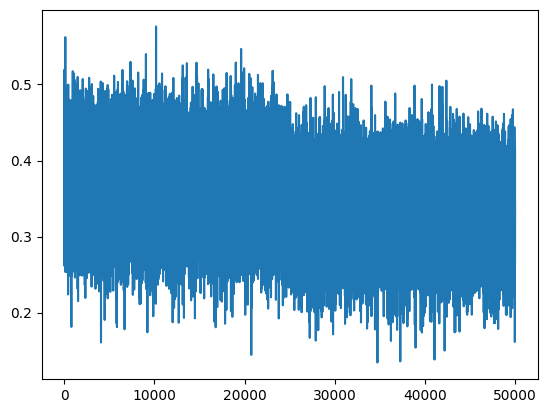

In [202]:
plt.plot(stepi, lossi)

In [203]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 +b1)
logits = h @ W2 +b2
loss = F.cross_entropy(logits, Ytr)
print(f'Development Loss:{loss.item():.3f}')

Development Loss:2.161


In [204]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 +b1)
logits = h @ W2 +b2
loss = F.cross_entropy(logits, Ydev)
print(f'Development Loss:{loss.item():.3f}')

Development Loss:2.194


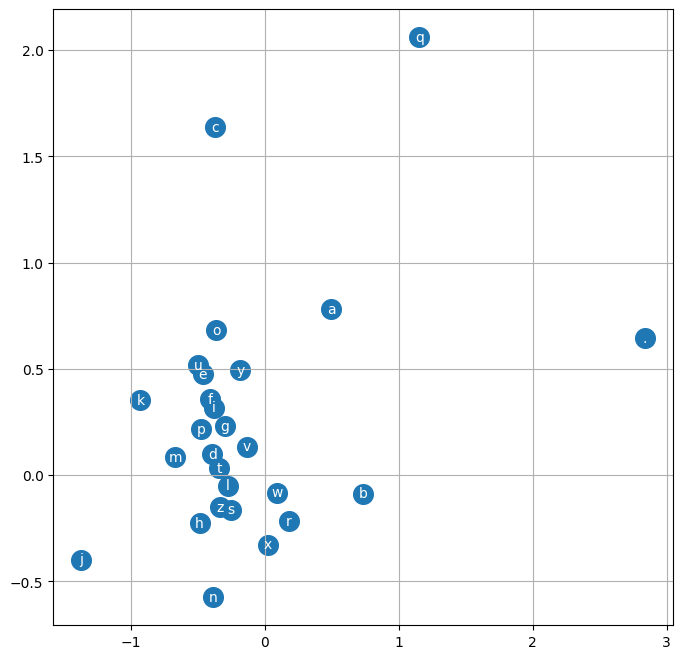

In [211]:
plt.figure(figsize = (8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha = "center", va = "center", color = 'white')
plt.grid('minor')

In [213]:
g = torch.Generator().manual_seed(21474483647+1)
block_size = 3
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix ==0:
            break
    print(''.join(itos[i] for i in out))

raiden.
khoreek.
taigh.
oze.
jasliyah.
lavi.
nari.
javen.
chricyn.
ley.
torriah.
haye.
nouchlonola.
truela.
owyton.
dhaha.
lucesionelly.
daige.
ily.
dayce.
